In [16]:
import io
import re
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from datasets import Dataset as HFDataset, DatasetDict, ClassLabel
from transformers import BertTokenizer
from tqdm import tqdm

In [17]:
# Hyperparameters
SEED = 42
torch.manual_seed(SEED)
MAX_LEN = 64
BATCH_SIZE = 32
EMBED_SIZE = 256
NUM_LAYERS = 2
HEADS = 8
FORWARD_EXPANSION = 4
DROPOUT = 0.1
NUM_CLASSES = 3
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import random
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Casting the dataset:   0%|          | 0/2264 [00:00<?, ? examples/s]

Total samples loaded: 2264
                                            sentence  label label_name
0  According to Gran , the company has no plans t...      1    Neutral
1  For the last quarter of 2010 , Componenta 's n...      2   Positive
2  In the third quarter of 2010 , net sales incre...      2   Positive
3  Operating profit rose to EUR 13.1 mn from EUR ...      2   Positive
4  Operating profit totalled EUR 21.1 mn , up fro...      2   Positive


/var/folders/s2/zxs3bhx56236pxvkcwd8kfjr0000gn/T/ipykernel_31495/3797408644.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_name', data=df, palette='viridis', order=['Negative', 'Neutral', 'Positive'])


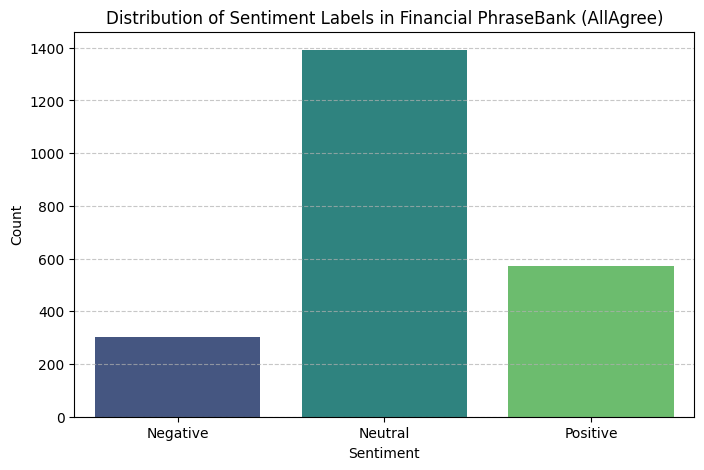


Label Counts:
label_name
Neutral     1391
Positive     570
Negative     303
Name: count, dtype: int64


In [18]:
def load_financial_phrasebank_manual(split_name="sentences_allagree"):
    """Load Financial PhraseBank from Hugging Face (zip)."""
    _URL = "https://huggingface.co/datasets/financial_phrasebank/resolve/main/data/FinancialPhraseBank-v1.0.zip"
    if split_name == "sentences_allagree":
        target_filename = "FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"
    elif split_name == "sentences_75agree":
        target_filename = "FinancialPhraseBank-v1.0/Sentences_75Agree.txt"
    elif split_name == "sentences_66agree":
        target_filename = "FinancialPhraseBank-v1.0/Sentences_66Agree.txt"
    elif split_name == "sentences_50agree":
        target_filename = "FinancialPhraseBank-v1.0/Sentences_50Agree.txt"
    else:
        raise ValueError(f"Unknown split: {split_name}")

    print(f"Downloading and extracting {_URL}...")
    response = requests.get(_URL)
    response.raise_for_status()
    data_list = []
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        with z.open(target_filename) as f:
            content = f.read().decode("iso-8859-1")
            for line in content.strip().split('\n'):
                try:
                    sentence, label = line.rsplit("@", 1)
                    data_list.append({"sentence": sentence.strip(), "label": label.strip()})
                except ValueError:
                    continue
    label_feature = ClassLabel(names=["negative", "neutral", "positive"])
    dataset = HFDataset.from_list(data_list)
    dataset = dataset.cast_column("label", label_feature)

    return DatasetDict({"train": dataset})

raw_ds = load_financial_phrasebank_manual("sentences_allagree")
df = raw_ds['train'].to_pandas()
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df['label_name'] = df['label'].map(label_map)
print(f"Total samples loaded: {len(df)}")
print(df.head())
plt.figure(figsize=(8, 5))
sns.countplot(x='label_name', data=df, palette='viridis', order=['Negative', 'Neutral', 'Positive'])
plt.title('Distribution of Sentiment Labels in Financial PhraseBank (AllAgree)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("\nLabel Counts:")
print(df['label_name'].value_counts())


In [19]:
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

print(f"Loaded {len(stop_words)} English stop words.")

# Preprocess text and split train/val
def clean_text(text):
    """Lowercase, strip non-alphanumeric (keep %$.,), remove stop words."""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s%\$\.,]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    filtered_words = [w for w in words if w not in stop_words]
    return ' '.join(filtered_words)

df['cleaned_sentence'] = df['sentence'].apply(clean_text)

print("\n--- Example of Cleaning ---")
print("Sample before cleaning:", df['sentence'].iloc[0])
print("Sample after cleaning: ", df['cleaned_sentence'].iloc[0])
print("---------------------------\n")


train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label'])
print(f"Training set size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print("\nTrain Label Distribution:\n", train_df['label_name'].value_counts(normalize=True))
print("\nValidation Label Distribution:\n", val_df['label_name'].value_counts(normalize=True))


Loaded 198 English stop words.

--- Example of Cleaning ---
Sample before cleaning: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Sample after cleaning:  according gran , company plans move production russia , although company growing .
---------------------------

Training set size: 1811 (80.0%)
Validation set size: 453 (20.0%)

Train Label Distribution:
 label_name
Neutral     0.614578
Positive    0.251795
Negative    0.133628
Name: proportion, dtype: float64

Validation Label Distribution:
 label_name
Neutral     0.613687
Positive    0.251656
Negative    0.134658
Name: proportion, dtype: float64


In [20]:
# Upsample minority classes, then build Dataset and DataLoaders
df_neutral = df[df['label_name'] == 'Neutral']
df_positive = df[df['label_name'] == 'Positive']
df_negative = df[df['label_name'] == 'Negative']

print("--- Original DataFrame Counts ---")
print(df['label_name'].value_counts())
print("---------------------------------\n")

n_samples = len(df_neutral)
df_positive_upsampled = resample(df_positive, replace=True, n_samples=n_samples, random_state=SEED)
df_negative_upsampled = resample(df_negative, replace=True, n_samples=n_samples, random_state=SEED)

df_upsampled = pd.concat([df_neutral, df_positive_upsampled, df_negative_upsampled])
df_upsampled = df_upsampled.sample(frac=1, random_state=SEED).reset_index(drop=True)

print("--- New DataFrame Counts After Upsampling ---")
print(df_upsampled['label_name'].value_counts())
print("---------------------------------------------\n")

train_df, val_df = train_test_split(
    df_upsampled,
    test_size=0.2,
    random_state=SEED,
    stratify=df_upsampled['label']
)

print(f"New Training set size: {len(train_df)}")
print(f"New Validation set size: {len(val_df)}\n")


class FinancialDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len=128):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = str(self.sentences[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'sentence_text': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = FinancialDataset(
    sentences=train_df['cleaned_sentence'].tolist(),
    labels=train_df['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
val_dataset = FinancialDataset(
    sentences=val_df['cleaned_sentence'].tolist(),
    labels=val_df['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

try:
    sample_batch = next(iter(train_loader))
    print("\n--- DataLoader Batch Verification ---")
    print("Input IDs shape:", sample_batch['input_ids'].shape)
    print("Attention Mask shape:", sample_batch['attention_mask'].shape)
    print("Labels shape:", sample_batch['label'].shape)
    print("Sample Sentence:", sample_batch['sentence_text'][0])
    print("Verification Successful!")
except Exception as e:
    print(f"An error occurred during verification: {e}")


--- Original DataFrame Counts ---
label_name
Neutral     1391
Positive     570
Negative     303
Name: count, dtype: int64
---------------------------------

--- New DataFrame Counts After Upsampling ---
label_name
Neutral     1391
Positive    1391
Negative    1391
Name: count, dtype: int64
---------------------------------------------

New Training set size: 3338
New Validation set size: 835


--- DataLoader Batch Verification ---
Input IDs shape: torch.Size([32, 64])
Attention Mask shape: torch.Size([32, 64])
Labels shape: torch.Size([32])
Sample Sentence: connectivity services include outsourced scan capture transfers paper invoices electronic format basware business transactions service enables customer receive send invoices electronic format .
Verification Successful!


In [21]:
# Custom transformer: SelfAttention, TransformerBlock, FinancialTransformer
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size needs to be div by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhqk,nkhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out, attention

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention_output, attention_weights = self.attention(value, key, query, mask)

        x = self.dropout(self.norm1(attention_output + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, attention_weights

class FinancialTransformer(nn.Module):
    def __init__(self, src_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length, num_classes):
        super(FinancialTransformer, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(embed_size, heads, dropout=dropout, forward_expansion=forward_expansion)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attention_mask=None):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

        if attention_mask is not None:
            mask = attention_mask.unsqueeze(1).unsqueeze(2)
        else:
            mask = None

        final_attention_weights = None
        for layer in self.layers:
            out, final_attention_weights = layer(out, out, out, mask=mask)

        logits = self.fc_out(out[:, 0, :])

        return logits, final_attention_weights


In [22]:
# Instantiate model
SRC_VOCAB_SIZE = tokenizer.vocab_size
model = FinancialTransformer(
    src_vocab_size=SRC_VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    num_layers=NUM_LAYERS,
    heads=HEADS,
    device=DEVICE,
    forward_expansion=FORWARD_EXPANSION,
    dropout=DROPOUT,
    max_length=MAX_LEN,
    num_classes=NUM_CLASSES
).to(DEVICE)

print(model)


FinancialTransformer(
  (word_embedding): Embedding(30522, 256)
  (position_embedding): Embedding(64, 256)
  (layers): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): SelfAttention(
        (values): Linear(in_features=32, out_features=32, bias=False)
        (keys): Linear(in_features=32, out_features=32, bias=False)
        (queries): Linear(in_features=32, out_features=32, bias=False)
        (fc_out): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc_out): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [23]:
# Training: setup model, optimizer, then train/val loop
SRC_VOCAB_SIZE = tokenizer.vocab_size
model = FinancialTransformer(
    src_vocab_size=SRC_VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    num_layers=NUM_LAYERS,
    heads=HEADS,
    device=DEVICE,
    forward_expansion=FORWARD_EXPANSION,
    dropout=DROPOUT,
    max_length=MAX_LEN,
    num_classes=NUM_CLASSES
).to(DEVICE)
model = model.to(memory_format=torch.contiguous_format)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}


for epoch in range(NUM_EPOCHS):

    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]", leave=False)

    for batch in train_loop:
        input_ids = batch['input_ids'].to(DEVICE, non_blocking=True).contiguous()
        attention_mask = batch['attention_mask'].to(DEVICE, non_blocking=True).contiguous()
        labels = batch['label'].to(DEVICE, non_blocking=True)

        outputs, _ = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]", leave=False)

    with torch.no_grad():
        for batch in val_loop:
            input_ids = batch['input_ids'].to(DEVICE, non_blocking=True).contiguous()
            attention_mask = batch['attention_mask'].to(DEVICE, non_blocking=True).contiguous()
            labels = batch['label'].to(DEVICE, non_blocking=True)

            outputs, _ = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")




Epoch 1/15 | Train Loss: 1.0888 | Train Acc: 40.65% | Val Loss: 0.9675 | Val Acc: 49.34%


Epoch 2/15 | Train Loss: 0.9777 | Train Acc: 50.75% | Val Loss: 0.8771 | Val Acc: 54.49%


Epoch 3/15 | Train Loss: 0.8925 | Train Acc: 55.27% | Val Loss: 0.8156 | Val Acc: 61.08%


Epoch 4/15 | Train Loss: 0.8259 | Train Acc: 60.04% | Val Loss: 0.7664 | Val Acc: 65.75%


Epoch 5/15 | Train Loss: 0.7640 | Train Acc: 63.24% | Val Loss: 0.7185 | Val Acc: 63.83%


Epoch 6/15 | Train Loss: 0.7078 | Train Acc: 67.05% | Val Loss: 0.6536 | Val Acc: 71.74%


Epoch 7/15 | Train Loss: 0.6338 | Train Acc: 72.08% | Val Loss: 0.5951 | Val Acc: 74.85%


Epoch 8/15 | Train Loss: 0.5818 | Train Acc: 75.73% | Val Loss: 0.5444 | Val Acc: 76.65%


Epoch 9/15 | Train Loss: 0.5154 | Train Acc: 78.64% | Val Loss: 0.4976 | Val Acc: 80.00%


Epoch 10/15 | Train Loss: 0.4432 | Train Acc: 82.20% | Val Loss: 0.4850 | Val Acc: 82.63%


Epoch 11/15 | Train Loss: 0.4143 | Train Acc: 83.64% | Val Loss: 0.5921 | Val Acc: 77.13%


Epoch 12/15 | Train Loss: 0.3828 | Train Acc: 84.81% | Val Loss: 0.4080 | Val Acc: 86.11%


Epoch 13/15 | Train Loss: 0.3467 | Train Acc: 86.61% | Val Loss: 0.4050 | Val Acc: 85.51%


Epoch 14/15 | Train Loss: 0.2980 | Train Acc: 88.80% | Val Loss: 0.4198 | Val Acc: 84.79%


Epoch 15/15 | Train Loss: 0.2790 | Train Acc: 89.72% | Val Loss: 0.3363 | Val Acc: 89.10%


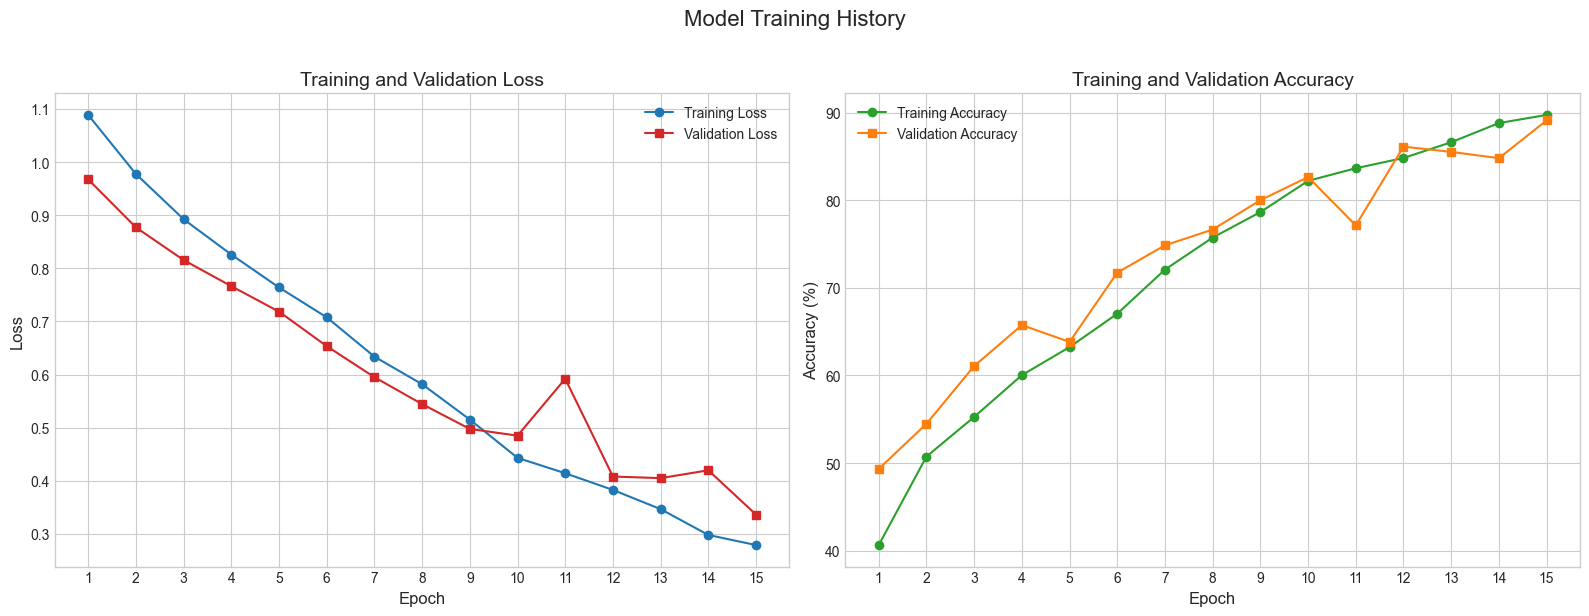

In [24]:
# Learning curves (loss and accuracy)
epochs_range = range(1, NUM_EPOCHS + 1)

try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(epochs_range, history['train_loss'], 'o-', label='Training Loss', color='tab:blue')
ax1.plot(epochs_range, history['val_loss'], 's-', label='Validation Loss', color='tab:red')
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.set_xticks(epochs_range)
ax1.grid(True)

ax2.plot(epochs_range, history['train_acc'], 'o-', label='Training Accuracy', color='tab:green')
ax2.plot(epochs_range, history['val_acc'], 's-', label='Validation Accuracy', color='tab:orange')
ax2.set_title('Training and Validation Accuracy', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.legend()
ax2.set_xticks(epochs_range)
ax2.grid(True)

plt.suptitle('Model Training History', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


Detailed Classification Report
Overall Accuracy: 0.8910
Weighted Precision: 0.8934
Weighted Recall:    0.8910
Weighted F1-Score:  0.8913
--------------------------------------------------

Per-Class Report:
              precision    recall  f1-score   support

    Negative       0.87      0.93      0.90       278
     Neutral       0.95      0.87      0.91       278
    Positive       0.86      0.87      0.86       279

    accuracy                           0.89       835
   macro avg       0.89      0.89      0.89       835
weighted avg       0.89      0.89      0.89       835



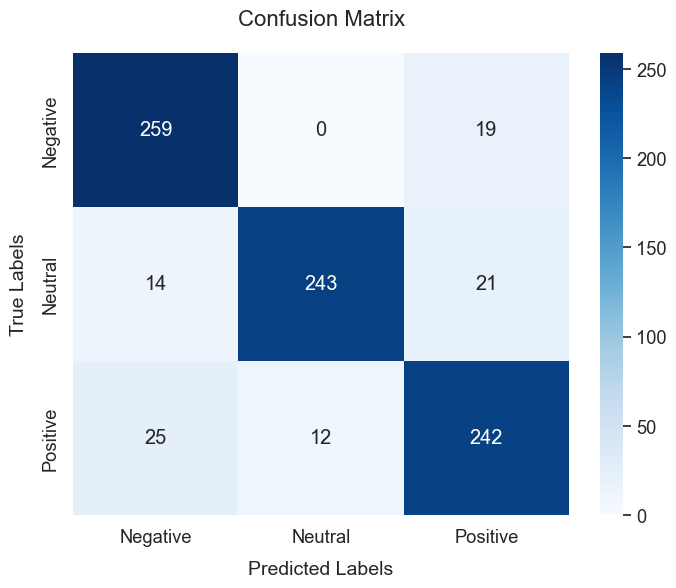

In [25]:
# Validation metrics and confusion matrix
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        outputs, _ = model(input_ids, attention_mask=attention_mask)
        _, predictions = torch.max(outputs, 1)
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

class_names = ['Negative', 'Neutral', 'Positive']
print("="*50)
print("Detailed Classification Report")
print("="*50)

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall:    {recall:.4f}")
print(f"Weighted F1-Score:  {f1:.4f}")
print("-" * 50)

print("\nPer-Class Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Labels', fontsize=14, labelpad=10)
plt.ylabel('True Labels', fontsize=14, labelpad=10)
plt.title('Confusion Matrix', fontsize=16, pad=20)
plt.show()


In [26]:
# Test inference: load test data, predict, save submission
try:
    # df_test = pd.read_csv('test_data.csv')
    df_test = pd.DataFrame({
        'sentence': [
            "The company reported a profit increase of 10%.",
            "Sales dropped significantly in the last quarter.",
            "The board of directors announced a meeting on Tuesday."
        ]
    })
    print("Test data loaded successfully.")
except FileNotFoundError:
    print("Error: Test file not found. Please specify the correct path.")

df_test['clean_sentence'] = df_test['sentence'].apply(str).apply(clean_text)

class FinancialTestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

test_dataset = FinancialTestDataset(
    texts=df_test['clean_sentence'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
test_predictions = []

print("Running prediction on test data...")
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        outputs, _ = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

        test_predictions.extend(preds.cpu().numpy())

# 0=Negative, 1=Neutral, 2=Positive (must match training)
label_map = {
    0: 'negative',
    1: 'neutral',
    2: 'positive'
}

final_labels = [label_map[p] for p in test_predictions]
df_test['predicted_label'] = final_labels
submission = df_test[['sentence', 'predicted_label']]
submission.to_csv('submission.csv', index=False)

print("="*50)
print("Predictions saved to 'submission.csv'")
print("="*50)
print(submission.head())


Test data loaded successfully.
Running prediction on test data...
Predictions saved to 'submission.csv'
                                            sentence predicted_label
0     The company reported a profit increase of 10%.        positive
1   Sales dropped significantly in the last quarter.        negative
2  The board of directors announced a meeting on ...         neutral


In [27]:
# Copy trained weights for attention visualization
viz_model = FinancialTransformer(
    src_vocab_size=tokenizer.vocab_size,
    embed_size=EMBED_SIZE,
    num_layers=NUM_LAYERS,
    heads=HEADS,
    device=DEVICE,
    forward_expansion=FORWARD_EXPANSION,
    dropout=DROPOUT,
    max_length=MAX_LEN,
    num_classes=NUM_CLASSES
).to(DEVICE)

viz_model.load_state_dict(model.state_dict())
viz_model.eval()
print("Model re-loaded specifically for visualization.")


Model re-loaded specifically for visualization.


Attention Weights Visualization


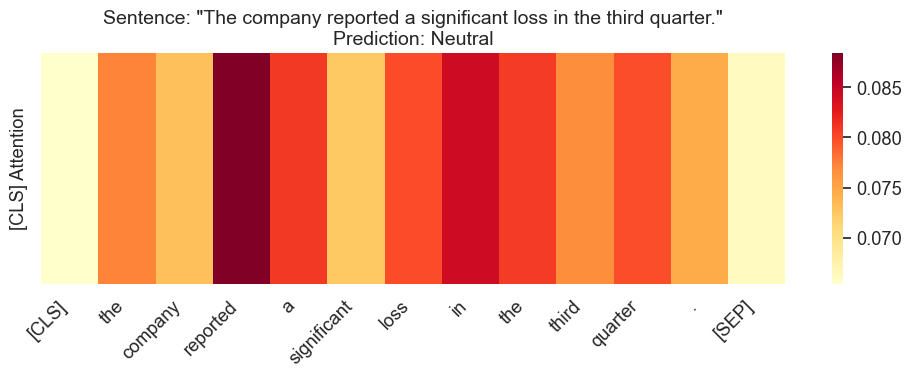

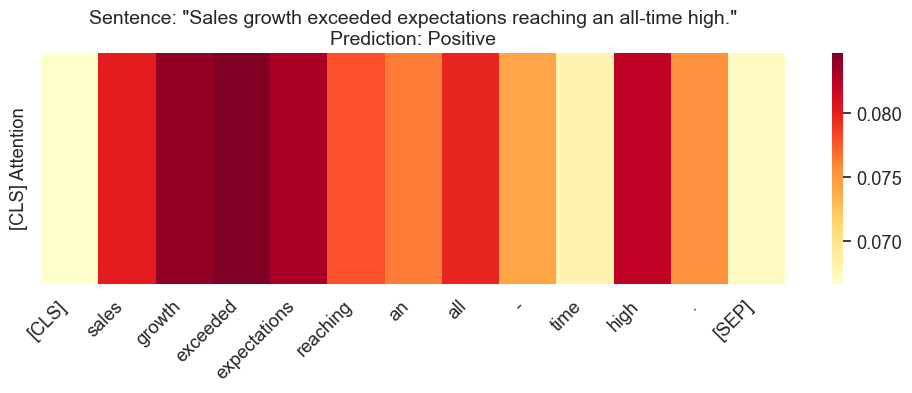

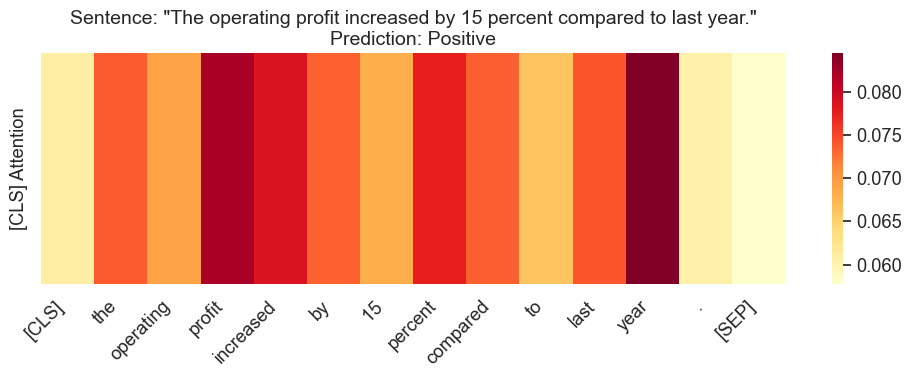

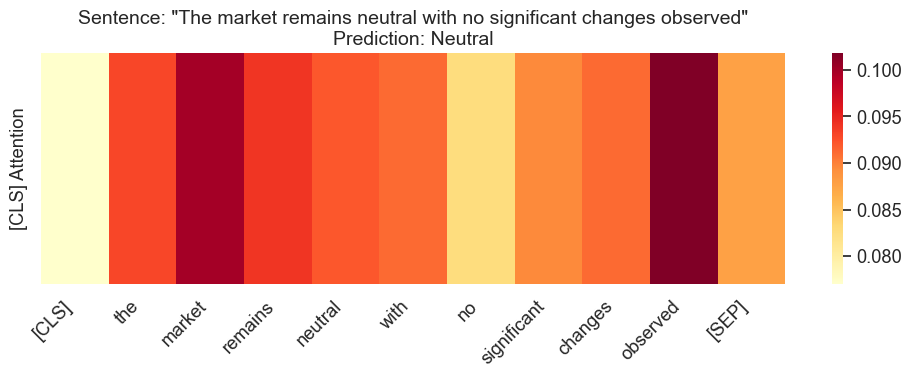

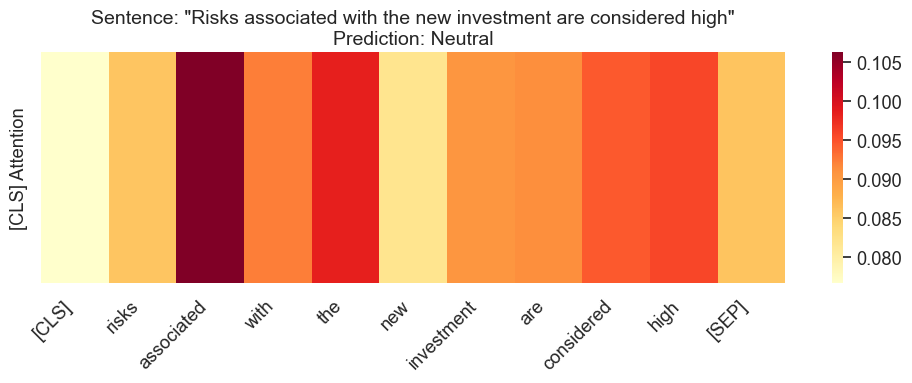

In [28]:
# Plot [CLS] attention over tokens for sample sentences
def visualize_attention(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LEN)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    with torch.no_grad():
        logits, attention = model(input_ids, attention_mask=attention_mask)

    pred_idx = torch.argmax(logits, dim=1).item()
    class_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_label = class_map[pred_idx]

    att_mat = attention[0].mean(dim=0).cpu().numpy()
    cls_attention = att_mat[0, :]

    valid_len = len(tokens)
    cls_attention = cls_attention[:valid_len]
    tokens = tokens[:valid_len]

    plt.figure(figsize=(12, 3))
    sns.heatmap([cls_attention], xticklabels=tokens, yticklabels=['[CLS] Attention'],
                cmap='YlOrRd', cbar=True, square=False, annot=False)

    plt.title(f"Sentence: \"{text}\"\nPrediction: {predicted_label}", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.show()


sample_sentences = [
    "The company reported a significant loss in the third quarter.",
    "Sales growth exceeded expectations reaching an all-time high.",
    "The operating profit increased by 15 percent compared to last year.",
    "The market remains neutral with no significant changes observed",
    "Risks associated with the new investment are considered high"
]



print("="*50)
print("Attention Weights Visualization")
print("="*50)

for sentence in sample_sentences:
    visualize_attention(sentence, viz_model, tokenizer, DEVICE)
